In [21]:
import numpy as np
# TODO: Clean up these scipy imports
import scipy.constants as sc
import scipy.signal as ss
from scipy.optimize import line_search, minimize
import matplotlib.pyplot as plt
from fte import fte
from gradFte import gradFte

## PCFM Waveform

In [22]:
# Number of waveforms to generate
nWaveforms = 1
# Waveform length in samples
M = 900
# Oversampling factor
K = 3
# Number of code values
N = int(M/K)
# Randomly generate a code sample matrix for each waveform
minAlpha = -sc.pi/K
maxAlpha = sc.pi/K
x = minAlpha + (maxAlpha - minAlpha) * np.random.rand(N,nWaveforms)
# Rectangular shaping filter with time support [0,Tp) = [0:K]
g = np.ones((K,1)) / K
g = np.concatenate((g,np.zeros((M-K,1))),axis=0)
# Construct an M x N basis matrix where each column is a basis function. This is
# NOT a basis in the mathematical sense; each column is equal to the previous
# column delayed by K samples
B = np.zeros((M,N))
for ii in range(N):
  B[:,ii] = np.cumsum(np.roll(g,ii*K))

## Frequency domain metric

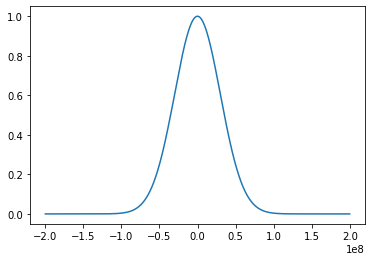

In [26]:

# Normalized full-width bandwidth
bw = 0.25
# Convert to standard deviation
# https://en.wikipedia.org/wiki/Full_width_at_half_maximum
sigma = bw/(2*np.sqrt(2*np.log(2)))
# Convert from standard deviation to Matlab's weird width factor
# https://www.mathworks.com/help/signal/ref/gausswin.html#References
alpha = 1 / (2*sigma)
sigma = (2*M-1-1)/(2*alpha)
# Create the template vector
u = ss.windows.gaussian(2*M-1,sigma)**2
# u[10*np.log10(u) <= -50] = 0
# TODO: Might have to clip values here
# Sample rate
fs = 200e6
# Frequency axis for plotting
freqStep = 2*fs/(2*M-1)
freqAxis = np.arange(-fs,fs,freqStep)
# initialSBar = fte(x,B,u)
plt.plot(freqAxis,u)


## Gradient-based optimization

In [27]:
# TODO: Implement this using scipy.optimize.line_search
f = lambda x: fte(x, B, u)[0]
gradf = lambda x: np.squeeze(gradFte(x, B, u))
res = minimize(f,x,jac=gradf,options={'disp':True})

         Current function value: 1200.203283
         Iterations: 0
         Function evaluations: 71
         Gradient evaluations: 59
